In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=3)
pd.set_option('display.precision', 3)
plt.style.use('ggplot')
%matplotlib inline

# 3. Polynomial Regression
## EDA

In [2]:
df = pd.read_csv("Bike-Sharing-Dataset/hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.288,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.273,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.273,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.288,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.288,0.75,0.0,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


- `instant`는 id 변수이니 삭제 
- `dteday`가 담고 있는 정보는 `season, yr, mnth`로 축약할 수 있을 것으로 보이니 삭제, `mnth`도 삭제
- `holiday, weekday, workingday`도 관련이 있어 보임
- `weathersit, temp, atemp, hum, windspeed`도 마찬가지, 그중 `temp, atemp`는 하나만 남겨두도록 하자
- `causal + registered = cnt`의 관련?

In [4]:
# instant, dteday, mnth 삭제
df.drop(['instant', 'dteday', 'mnth'], axis=1, inplace=True)

### 시간 관련 변수  EDA

In [5]:
TIMES = ['season', 'yr']

for time in TIMES:
    df[time] = df[time].astype('category')

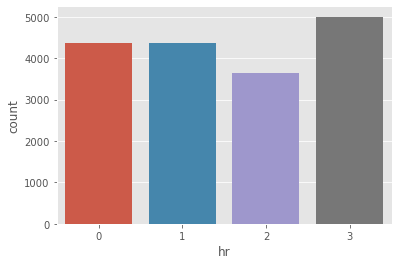

In [6]:
# hr: 아침(6-12), 점심(12-6), 저녁(6-12), 새벽(12-6) 으로 나누기
import warnings
warnings.filterwarnings('ignore')

HOURS = [[*range(6, 12)], [*(range(12, 18))], [*range(18,23)], [*range(0,6)]]

for idx, hour in enumerate(df['hr']):
    if hour in HOURS[0]:
        df['hr'][idx] = 0
    elif hour in HOURS[1]:
        df['hr'][idx] = 1
    elif hour in HOURS[2]:
        df['hr'][idx] = 2
    else:
        df['hr'][idx] = 3
else:
    sns.countplot(x='hr', data=df)

### 공휴일 관련 변수 EDA

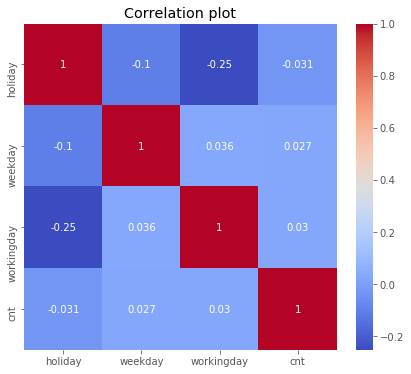

In [7]:
cor_matrix = df[['holiday', 'weekday', 'workingday','cnt']].corr()

fig, ax = plt.subplots(1, figsize=(7,6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation plot")
plt.show()

`workingday` 삭제

In [8]:
df.drop(['workingday'], axis=1, inplace=True)

In [9]:
# 주말과 주말이 아닌 날로 바꿔준다
df['weekday'] = df['weekday'].replace([0, 1, 2, 3, 4, 5, 6], [0, 0, 0, 0, 0, 1, 1])

### 날씨 관련 변수 EDA

In [10]:
print(df.columns)

Index(['season', 'yr', 'hr', 'holiday', 'weekday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt'],
      dtype='object')


In [11]:
weathers = [value for idx, value in enumerate(df.columns) if 5<=idx<=9]
print(weathers)

['weathersit', 'temp', 'atemp', 'hum', 'windspeed']


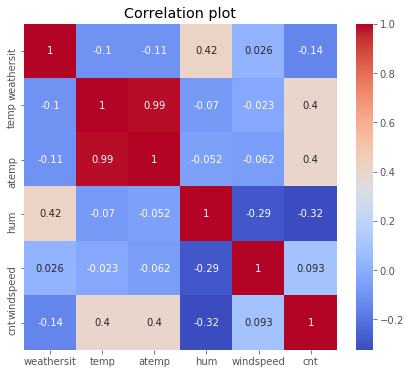

In [12]:
cor_matrix = df[weathers+['cnt']].corr()

fig, ax = plt.subplots(1, figsize=(7,6))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation plot")
plt.show()

`temp, atemp`중 하나 삭제 => atemp 삭제... 이유는 없음 <br>

In [13]:
df.drop(['atemp'], axis=1, inplace=True)

### casual, registered, cnt의 관계?

In [14]:
np.all(df.casual+df.registered == df.cnt)

True

이렇게 되면 regression을 하는 이유가 없으니 둘다 지워버린다

In [15]:
df.drop(['casual', 'registered'], axis=1, inplace=True)

In [16]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  category
 1   yr          17379 non-null  category
 2   hr          17379 non-null  int64   
 3   holiday     17379 non-null  int64   
 4   weekday     17379 non-null  int64   
 5   weathersit  17379 non-null  int64   
 6   temp        17379 non-null  float64 
 7   hum         17379 non-null  float64 
 8   windspeed   17379 non-null  float64 
 9   cnt         17379 non-null  int64   
dtypes: category(2), float64(3), int64(5)
memory usage: 1.1 MB
None
              hr    holiday    weekday  weathersit       temp        hum  \
count  17379.000  17379.000  17379.000   17379.000  17379.000  17379.000   
mean       1.534      0.029      0.288       1.425      0.497      0.627   
std        1.152      0.167      0.453       0.639      0.193      0.193   
min        0.00

### Dummy vars

In [17]:
pd.get_dummies(df).columns

Index(['hr', 'holiday', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed',
       'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'yr_0', 'yr_1'],
      dtype='object')

In [18]:
df = pd.get_dummies(df)
print(df.columns)
print(df.head())

Index(['hr', 'holiday', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed',
       'cnt', 'season_1', 'season_2', 'season_3', 'season_4', 'yr_0', 'yr_1'],
      dtype='object')
   hr  holiday  weekday  weathersit  temp   hum  windspeed  cnt  season_1  \
0   3        0        1           1  0.24  0.81        0.0   16         1   
1   3        0        1           1  0.22  0.80        0.0   40         1   
2   3        0        1           1  0.22  0.80        0.0   32         1   
3   3        0        1           1  0.24  0.75        0.0   13         1   
4   3        0        1           1  0.24  0.75        0.0    1         1   

   season_2  season_3  season_4  yr_0  yr_1  
0         0         0         0     1     0  
1         0         0         0     1     0  
2         0         0         0     1     0  
3         0         0         0     1     0  
4         0         0         0     1     0  


`yr`은 `holiday, weekday`처럼 그냥 numeric한 변수로 바꾸겠음

In [19]:
df['yr'] = df['yr_1']
df.drop(['yr_0', 'yr_1'], axis=1, inplace=True)

## Polynomial Regression

In [20]:
print(df.dtypes)

hr              int64
holiday         int64
weekday         int64
weathersit      int64
temp          float64
hum           float64
windspeed     float64
cnt             int64
season_1        uint8
season_2        uint8
season_3        uint8
season_4        uint8
yr              uint8
dtype: object


In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse


preprocessor = ColumnTransformer([("scaler", StandardScaler(), ['temp','hum','windspeed'])])
model = LinearRegression()

def poly_mse(degree=2):
    'returns train mse and test mse'
    X, y = df.iloc[:, :-1], df.cnt
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X[['temp','hum','windspeed']])
    X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names())
    X_poly = X_poly[['1']+list(X_poly.columns[4:])]
    X = pd.concat([X, X_poly], axis=1)
    X[['temp','hum','windspeed']] = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)
    model.fit(X_train, y_train)
    return mse(y_train, model.predict(X_train)), mse(y_test, model.predict(X_test))

In [24]:
train_mse, test_mse = [], []

for i in range(2, 13):
    tmp1, tmp2 = poly_mse(i)
    train_mse.append(tmp1)
    test_mse.append(tmp2)

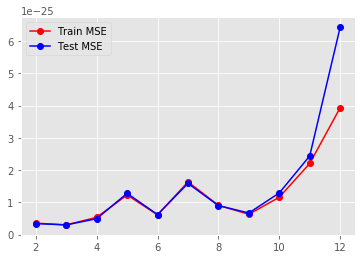

In [25]:
plt.plot(range(2, 13), train_mse, 'ro-', label='Train MSE')
plt.plot(range(2, 13), test_mse, 'bo-', label='Test MSE')
plt.legend()
plt.show()